# Import Libraries

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import plotting libraries
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.io as pio
import matplotlib.pyplot as plt
%matplotlib inline

# modeling libraries
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM
from keras.utils import plot_model

# Pre-Processing & evaluation Libraries
from sklearn.preprocessing import MinMaxScaler, Normalizer, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from scipy.stats import pearsonr as r


# Run Model & load data Functions

In [2]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)


In [3]:
def run_model(x_train, y_train, x_val, y_val, epochs=500, batch_size=400, method='LSTM'):
    classifier = {
                  'LSTM' : LSTM,
                 }


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    X = classifier[method](512, return_sequences=True)(X)
    #X = classifier[method](256, return_sequences=True)(X)
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(inputs, [out1, out2, out3])
    #opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.001)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer= opt, metrics=['mae'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, [y_val[:, 0], y_val[:, 1], y_val[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

# Load Data

In [4]:
df = pd.read_csv("data\Reservoir_data.csv")

df.drop('Unnamed: 0', axis  =1, inplace = True)
df.drop('index', axis = 1, inplace =True)
df.head(20)

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,DP_CHOKE_SIZE,AVG_WHP_P,AVG_WHT_P,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
0,2008-07-13,24.00,260.866875,103.292880,160.151955,21.052993,69.539413,100.714919,52.381899,1735.26,252235.23,14.00
1,2008-07-14,5.57,256.248230,104.017718,156.649912,27.223459,68.016167,99.598318,71.115352,592.36,88949.00,11.37
2,2008-07-15,24.00,254.982785,103.967009,156.332844,27.277954,66.948884,98.649941,67.590753,2532.21,373786.28,15.84
3,2008-07-16,24.00,251.475921,104.210557,155.817187,30.650552,63.663812,95.658734,73.782251,3030.71,447840.09,19.13
4,2008-07-17,24.00,249.346191,104.339184,155.760939,32.562537,61.337700,93.585252,78.035440,3288.08,474614.43,17.58
5,2008-07-18,24.00,251.501571,104.333687,155.278797,30.051586,64.305031,96.222774,75.749887,2780.06,410359.82,21.05
6,2008-07-19,24.00,251.508943,104.353860,155.359876,30.083934,64.164310,96.149067,75.335040,2774.38,420865.05,16.40
7,2008-07-20,24.00,251.457711,104.378397,155.351759,30.117950,64.128160,96.105952,75.616605,2791.01,408766.41,16.43
8,2008-07-21,24.00,251.724326,104.398653,155.234376,29.830638,64.560483,96.489950,76.077794,2743.10,402199.56,16.32
9,2008-07-22,24.00,251.858368,104.407234,155.172133,29.748209,64.770177,96.686235,77.017105,2717.44,399221.04,16.45


# Pre-Processing

In [5]:
val_fraction = 0.15
test_fraction = 0.15
X = df[['ON_STREAM_HRS','AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
        'AVG_DP_TUBING', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P','DP_CHOKE_SIZE', 'AVG_WHT_P']]
Y = df[['BORE_OIL_VOL', 'BORE_GAS_VOL','BORE_WAT_VOL']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_fraction, shuffle = False)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size = val_fraction/(1-test_fraction), shuffle = False)

In [6]:
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train.as_matrix())
x_val_norm = scaler_x.transform(x_val.as_matrix())
x_test_norm = scaler_x.transform(X_test.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train.as_matrix())
y_val_norm = scaler_y.transform(y_val.as_matrix())
y_test_norm = scaler_y.transform(Y_test.as_matrix())

x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=35)
x_val, y_val = create_timeblock(x_val_norm, y_val_norm, look_back=35)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=35)

# of data:  1870
# of data:  374
# of data:  374


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



# Training & Validation of the RNN Model 

In [7]:
model_LSTM, history_LSTM = run_model(x_train, y_train,x_val, y_val,  epochs=300, batch_size=400, method='LSTM')

Epoch 1/300
5/5 [==============================] - 33s 7s/step - loss: 0.5484 - dense_1_loss: 0.1565 - dense_2_loss: 0.2819 - dense_3_loss: 0.1100 - dense_1_mae: 0.3288 - dense_2_mae: 0.4373 - dense_3_mae: 0.2622 - val_loss: 0.0091 - val_dense_1_loss: 0.0021 - val_dense_2_loss: 3.5960e-04 - val_dense_3_loss: 0.0066 - val_dense_1_mae: 0.0433 - val_dense_2_mae: 0.0152 - val_dense_3_mae: 0.0589
Epoch 2/300
5/5 [==============================] - 33s 7s/step - loss: 0.3457 - dense_1_loss: 0.1309 - dense_2_loss: 0.1258 - dense_3_loss: 0.0890 - dense_1_mae: 0.2823 - dense_2_mae: 0.2756 - dense_3_mae: 0.2628 - val_loss: 0.0910 - val_dense_1_loss: 0.0282 - val_dense_2_loss: 0.0135 - val_dense_3_loss: 0.0492 - val_dense_1_mae: 0.1673 - val_dense_2_mae: 0.1153 - val_dense_3_mae: 0.2161
Epoch 3/300
5/5 [==============================] - 36s 7s/step - loss: 0.3708 - dense_1_loss: 0.1552 - dense_2_loss: 0.1294 - dense_3_loss: 0.0862 - dense_1_mae: 0.3147 - dense_2_mae: 0.2997 - dense_3_mae: 0.2542 -

Epoch 22/300
5/5 [==============================] - 33s 7s/step - loss: 0.0518 - dense_1_loss: 0.0156 - dense_2_loss: 0.0166 - dense_3_loss: 0.0195 - dense_1_mae: 0.0906 - dense_2_mae: 0.0935 - dense_3_mae: 0.1039 - val_loss: 0.0078 - val_dense_1_loss: 9.9998e-04 - val_dense_2_loss: 8.9340e-04 - val_dense_3_loss: 0.0059 - val_dense_1_mae: 0.0297 - val_dense_2_mae: 0.0276 - val_dense_3_mae: 0.0433
Epoch 23/300
5/5 [==============================] - 33s 7s/step - loss: 0.0514 - dense_1_loss: 0.0159 - dense_2_loss: 0.0168 - dense_3_loss: 0.0186 - dense_1_mae: 0.0885 - dense_2_mae: 0.0905 - dense_3_mae: 0.1007 - val_loss: 0.0107 - val_dense_1_loss: 0.0027 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0058 - val_dense_1_mae: 0.0507 - val_dense_2_mae: 0.0461 - val_dense_3_mae: 0.0422
Epoch 24/300
5/5 [==============================] - 33s 7s/step - loss: 0.0495 - dense_1_loss: 0.0138 - dense_2_loss: 0.0142 - dense_3_loss: 0.0214 - dense_1_mae: 0.0791 - dense_2_mae: 0.0814 - dense_3_mae: 0

Epoch 43/300
5/5 [==============================] - 33s 7s/step - loss: 0.0485 - dense_1_loss: 0.0152 - dense_2_loss: 0.0163 - dense_3_loss: 0.0170 - dense_1_mae: 0.0906 - dense_2_mae: 0.0941 - dense_3_mae: 0.0938 - val_loss: 0.0100 - val_dense_1_loss: 0.0020 - val_dense_2_loss: 0.0020 - val_dense_3_loss: 0.0060 - val_dense_1_mae: 0.0436 - val_dense_2_mae: 0.0434 - val_dense_3_mae: 0.0516
Epoch 44/300
5/5 [==============================] - 33s 7s/step - loss: 0.0490 - dense_1_loss: 0.0144 - dense_2_loss: 0.0148 - dense_3_loss: 0.0197 - dense_1_mae: 0.0761 - dense_2_mae: 0.0788 - dense_3_mae: 0.1066 - val_loss: 0.0073 - val_dense_1_loss: 7.4457e-04 - val_dense_2_loss: 8.5049e-04 - val_dense_3_loss: 0.0058 - val_dense_1_mae: 0.0261 - val_dense_2_mae: 0.0278 - val_dense_3_mae: 0.0418
Epoch 45/300
5/5 [==============================] - 33s 7s/step - loss: 0.0531 - dense_1_loss: 0.0165 - dense_2_loss: 0.0175 - dense_3_loss: 0.0191 - dense_1_mae: 0.0984 - dense_2_mae: 0.1022 - dense_3_mae: 0

Epoch 64/300
5/5 [==============================] - 32s 6s/step - loss: 0.0455 - dense_1_loss: 0.0137 - dense_2_loss: 0.0150 - dense_3_loss: 0.0168 - dense_1_mae: 0.0837 - dense_2_mae: 0.0883 - dense_3_mae: 0.0937 - val_loss: 0.0066 - val_dense_1_loss: 6.1464e-04 - val_dense_2_loss: 6.1822e-04 - val_dense_3_loss: 0.0053 - val_dense_1_mae: 0.0228 - val_dense_2_mae: 0.0224 - val_dense_3_mae: 0.0411
Epoch 65/300
5/5 [==============================] - 32s 6s/step - loss: 0.0465 - dense_1_loss: 0.0137 - dense_2_loss: 0.0145 - dense_3_loss: 0.0183 - dense_1_mae: 0.0731 - dense_2_mae: 0.0753 - dense_3_mae: 0.0974 - val_loss: 0.0086 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 0.0015 - val_dense_3_loss: 0.0059 - val_dense_1_mae: 0.0335 - val_dense_2_mae: 0.0375 - val_dense_3_mae: 0.0431
Epoch 66/300
5/5 [==============================] - 32s 6s/step - loss: 0.0507 - dense_1_loss: 0.0165 - dense_2_loss: 0.0177 - dense_3_loss: 0.0166 - dense_1_mae: 0.0946 - dense_2_mae: 0.0989 - dense_3_mae: 0

Epoch 85/300
5/5 [==============================] - 36s 7s/step - loss: 0.0552 - dense_1_loss: 0.0178 - dense_2_loss: 0.0185 - dense_3_loss: 0.0189 - dense_1_mae: 0.1025 - dense_2_mae: 0.1052 - dense_3_mae: 0.1029 - val_loss: 0.0185 - val_dense_1_loss: 0.0058 - val_dense_2_loss: 0.0057 - val_dense_3_loss: 0.0069 - val_dense_1_mae: 0.0756 - val_dense_2_mae: 0.0748 - val_dense_3_mae: 0.0621
Epoch 86/300
5/5 [==============================] - 37s 7s/step - loss: 0.0561 - dense_1_loss: 0.0140 - dense_2_loss: 0.0149 - dense_3_loss: 0.0273 - dense_1_mae: 0.0776 - dense_2_mae: 0.0778 - dense_3_mae: 0.1276 - val_loss: 0.0089 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 0.0022 - val_dense_3_loss: 0.0054 - val_dense_1_mae: 0.0335 - val_dense_2_mae: 0.0458 - val_dense_3_mae: 0.0405
Epoch 87/300
5/5 [==============================] - 37s 7s/step - loss: 0.0607 - dense_1_loss: 0.0183 - dense_2_loss: 0.0193 - dense_3_loss: 0.0230 - dense_1_mae: 0.1053 - dense_2_mae: 0.1082 - dense_3_mae: 0.1153 - 

Epoch 106/300
5/5 [==============================] - 38s 8s/step - loss: 0.0447 - dense_1_loss: 0.0141 - dense_2_loss: 0.0146 - dense_3_loss: 0.0160 - dense_1_mae: 0.0820 - dense_2_mae: 0.0855 - dense_3_mae: 0.0893 - val_loss: 0.0059 - val_dense_1_loss: 2.7356e-04 - val_dense_2_loss: 2.1497e-04 - val_dense_3_loss: 0.0054 - val_dense_1_mae: 0.0136 - val_dense_2_mae: 0.0113 - val_dense_3_mae: 0.0436
Epoch 107/300
5/5 [==============================] - 38s 8s/step - loss: 0.0408 - dense_1_loss: 0.0123 - dense_2_loss: 0.0131 - dense_3_loss: 0.0154 - dense_1_mae: 0.0717 - dense_2_mae: 0.0753 - dense_3_mae: 0.0884 - val_loss: 0.0060 - val_dense_1_loss: 2.8109e-04 - val_dense_2_loss: 3.2912e-04 - val_dense_3_loss: 0.0054 - val_dense_1_mae: 0.0152 - val_dense_2_mae: 0.0161 - val_dense_3_mae: 0.0434
Epoch 108/300
5/5 [==============================] - 39s 8s/step - loss: 0.0405 - dense_1_loss: 0.0124 - dense_2_loss: 0.0132 - dense_3_loss: 0.0148 - dense_1_mae: 0.0708 - dense_2_mae: 0.0747 - den

Epoch 147/300
5/5 [==============================] - 38s 8s/step - loss: 0.0410 - dense_1_loss: 0.0130 - dense_2_loss: 0.0136 - dense_3_loss: 0.0144 - dense_1_mae: 0.0719 - dense_2_mae: 0.0746 - dense_3_mae: 0.0808 - val_loss: 0.0070 - val_dense_1_loss: 6.1969e-04 - val_dense_2_loss: 6.6029e-04 - val_dense_3_loss: 0.0058 - val_dense_1_mae: 0.0220 - val_dense_2_mae: 0.0227 - val_dense_3_mae: 0.0425
Epoch 148/300
5/5 [==============================] - 51s 10s/step - loss: 0.0415 - dense_1_loss: 0.0130 - dense_2_loss: 0.0140 - dense_3_loss: 0.0145 - dense_1_mae: 0.0799 - dense_2_mae: 0.0842 - dense_3_mae: 0.0847 - val_loss: 0.0062 - val_dense_1_loss: 2.6476e-04 - val_dense_2_loss: 2.2008e-04 - val_dense_3_loss: 0.0057 - val_dense_1_mae: 0.0133 - val_dense_2_mae: 0.0115 - val_dense_3_mae: 0.0423
Epoch 149/300
5/5 [==============================] - 38s 8s/step - loss: 0.0395 - dense_1_loss: 0.0125 - dense_2_loss: 0.0129 - dense_3_loss: 0.0140 - dense_1_mae: 0.0720 - dense_2_mae: 0.0742 - de

5/5 [==============================] - 36s 7s/step - loss: 0.0411 - dense_1_loss: 0.0122 - dense_2_loss: 0.0131 - dense_3_loss: 0.0158 - dense_1_mae: 0.0649 - dense_2_mae: 0.0682 - dense_3_mae: 0.0814 - val_loss: 0.0097 - val_dense_1_loss: 2.1094e-04 - val_dense_2_loss: 1.5713e-04 - val_dense_3_loss: 0.0094 - val_dense_1_mae: 0.0115 - val_dense_2_mae: 0.0086 - val_dense_3_mae: 0.0676
Epoch 188/300
5/5 [==============================] - 35s 7s/step - loss: 0.0494 - dense_1_loss: 0.0137 - dense_2_loss: 0.0142 - dense_3_loss: 0.0215 - dense_1_mae: 0.0806 - dense_2_mae: 0.0836 - dense_3_mae: 0.1201 - val_loss: 0.0060 - val_dense_1_loss: 3.2808e-04 - val_dense_2_loss: 1.6534e-04 - val_dense_3_loss: 0.0055 - val_dense_1_mae: 0.0152 - val_dense_2_mae: 0.0092 - val_dense_3_mae: 0.0445
Epoch 189/300
5/5 [==============================] - 42s 8s/step - loss: 0.0545 - dense_1_loss: 0.0128 - dense_2_loss: 0.0136 - dense_3_loss: 0.0280 - dense_1_mae: 0.0747 - dense_2_mae: 0.0748 - dense_3_mae: 0.13

Epoch 208/300
5/5 [==============================] - 36s 7s/step - loss: 0.0377 - dense_1_loss: 0.0114 - dense_2_loss: 0.0123 - dense_3_loss: 0.0140 - dense_1_mae: 0.0702 - dense_2_mae: 0.0748 - dense_3_mae: 0.0785 - val_loss: 0.0082 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0054 - val_dense_1_mae: 0.0325 - val_dense_2_mae: 0.0370 - val_dense_3_mae: 0.0416
Epoch 209/300
5/5 [==============================] - 36s 7s/step - loss: 0.0370 - dense_1_loss: 0.0111 - dense_2_loss: 0.0118 - dense_3_loss: 0.0141 - dense_1_mae: 0.0642 - dense_2_mae: 0.0672 - dense_3_mae: 0.0824 - val_loss: 0.0074 - val_dense_1_loss: 3.2074e-04 - val_dense_2_loss: 3.9809e-04 - val_dense_3_loss: 0.0067 - val_dense_1_mae: 0.0151 - val_dense_2_mae: 0.0166 - val_dense_3_mae: 0.0493
Epoch 210/300
5/5 [==============================] - 35s 7s/step - loss: 0.0362 - dense_1_loss: 0.0108 - dense_2_loss: 0.0116 - dense_3_loss: 0.0138 - dense_1_mae: 0.0696 - dense_2_mae: 0.0732 - dense_3_mae

Epoch 249/300
5/5 [==============================] - 41s 8s/step - loss: 0.0372 - dense_1_loss: 0.0120 - dense_2_loss: 0.0125 - dense_3_loss: 0.0127 - dense_1_mae: 0.0764 - dense_2_mae: 0.0787 - dense_3_mae: 0.0765 - val_loss: 0.0068 - val_dense_1_loss: 5.5964e-04 - val_dense_2_loss: 4.3238e-04 - val_dense_3_loss: 0.0058 - val_dense_1_mae: 0.0204 - val_dense_2_mae: 0.0173 - val_dense_3_mae: 0.0445
Epoch 250/300
5/5 [==============================] - 35s 7s/step - loss: 0.0360 - dense_1_loss: 0.0114 - dense_2_loss: 0.0122 - dense_3_loss: 0.0123 - dense_1_mae: 0.0655 - dense_2_mae: 0.0670 - dense_3_mae: 0.0716 - val_loss: 0.0086 - val_dense_1_loss: 1.6210e-04 - val_dense_2_loss: 2.0995e-04 - val_dense_3_loss: 0.0082 - val_dense_1_mae: 0.0101 - val_dense_2_mae: 0.0111 - val_dense_3_mae: 0.0605
Epoch 251/300
5/5 [==============================] - 35s 7s/step - loss: 0.0366 - dense_1_loss: 0.0115 - dense_2_loss: 0.0123 - dense_3_loss: 0.0127 - dense_1_mae: 0.0762 - dense_2_mae: 0.0795 - den

5/5 [==============================] - 35s 7s/step - loss: 0.0329 - dense_1_loss: 0.0098 - dense_2_loss: 0.0105 - dense_3_loss: 0.0126 - dense_1_mae: 0.0673 - dense_2_mae: 0.0713 - dense_3_mae: 0.0776 - val_loss: 0.0072 - val_dense_1_loss: 4.8271e-04 - val_dense_2_loss: 3.0040e-04 - val_dense_3_loss: 0.0064 - val_dense_1_mae: 0.0179 - val_dense_2_mae: 0.0132 - val_dense_3_mae: 0.0497
Epoch 290/300
5/5 [==============================] - 35s 7s/step - loss: 0.0326 - dense_1_loss: 0.0096 - dense_2_loss: 0.0104 - dense_3_loss: 0.0126 - dense_1_mae: 0.0606 - dense_2_mae: 0.0632 - dense_3_mae: 0.0732 - val_loss: 0.0098 - val_dense_1_loss: 2.1135e-04 - val_dense_2_loss: 5.6056e-04 - val_dense_3_loss: 0.0090 - val_dense_1_mae: 0.0114 - val_dense_2_mae: 0.0206 - val_dense_3_mae: 0.0659
Epoch 291/300
5/5 [==============================] - 36s 7s/step - loss: 0.0323 - dense_1_loss: 0.0100 - dense_2_loss: 0.0104 - dense_3_loss: 0.0119 - dense_1_mae: 0.0692 - dense_2_mae: 0.0705 - dense_3_mae: 0.07

In [8]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_val)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_val)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

# Results & Plotting  

In [9]:

def plot_iterative_flow(t, q_actual, q_pred, val_fraction, test_fraction):
    lowrate_type = {0:"Actual field oil rate",
                    1: "Actual field gas rate",
                    2: "Actual field water rate"}
    trace1 = go.Scatter(x = t,
                        y = q_actual,
                        name = lowrate_type[i])
    train_tail = int((1 -val_fraction - test_fraction) * q_pred.shape[0])
    trace2 = go.Scatter(x = t[0:train_tail],
                        y = q_pred[0:train_tail],
                        name = "Training set")

    val_tail = int((1-test_fraction) * q_pred.shape[0])
    trace3 = go.Scatter(x = t[train_tail:val_tail],
                        y = q_pred[train_tail:val_tail],
                        name = "Val set")
    trace4 = go.Scatter(x = t[val_tail:],
                        y = q_pred[val_tail:],
                        name = "Test set")
    data = [trace1, trace2, trace3, trace4]
    layout = {"title": "Flow rate well"}
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)
    
t = np.arange(len(df))
for i in range(y_act.shape[1]):
    plot_iterative_flow(t,
                   y_act[:, i], y_pred[:, i], val_fraction=val_fraction, test_fraction=test_fraction)
S = 0
cum = []
for i in y_pred_train[:,0]:
    S = S + i
    cum.append(S)
for i in y_pred_dev[:,0]:
    S+= i
    cum.append(S)
for i in y_pred_test[:,0]:
    S+= i
    cum.append(S)
    
T = 0
re = []
for i in y_train_act[:,0]:
    T += i
    re.append(T)
for i in y_dev_act[:,0]:
    T += i
    re.append(T)
for i in y_test_act[:,0]:
    T += i
    re.append(T)
a = np.asarray(cum)
b = np.asarray(re)

trace1 = go.Scatter(x = np.arange(len(a)),
                    y = a.reshape(-1,),
                   name = "Prediction")
trace2 = go.Scatter(x = np.arange(len(a)),
                    y = b.reshape(-1,),
                   name = "Actual values")
data = [trace1, trace2]
layout = go.Layout(title = "Cummulative field oil production of Long short term memory")
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#GAS
S2 = 0
cum2 = []
for i in y_pred_train[:,1]:
    S2 = S2 + i
    cum2.append(S2)
for i in y_pred_dev[:,1]:
    S2+= i
    cum2.append(S2)
for i in y_pred_test[:,1]:
    S2+= i
    cum2.append(S2)
    
T2 = 0
re2 = []
for i in y_train_act[:,1]:
    T2 += i
    re2.append(T2)
for i in y_dev_act[:,1]:
    T2 += i
    re2.append(T2)
for i in y_test_act[:,1]:
    T2 += i
    re2.append(T2)
a2 = np.asarray(cum2)
b2 = np.asarray(re2)

trace1 = go.Scatter(x = np.arange(len(a2)),
                    y = a2.reshape(-1,),
                   name = "Prediction")
trace2 = go.Scatter(x = np.arange(len(a2)),
                    y = b2.reshape(-1,),
                   name = "Actual values")
data = [trace1, trace2]
layout = go.Layout(title = "Cummulative field gas production of Long short term memory")
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#WATER
S3 = 0
cum3 = []
for i in y_pred_train[:,2]:
    S3 = S3 + i
    cum3.append(S3)
for i in y_pred_dev[:,2]:
    S3+= i
    cum3.append(S3)
for i in y_pred_test[:,2]:
    S3+= i
    cum3.append(S3)
    
T3 = 0
re3 = []
for i in y_train_act[:,2]:
    T3 += i
    re3.append(T3)
for i in y_dev_act[:,2]:
    T3 += i
    re3.append(T3)
for i in y_test_act[:,2]:
    T3 += i
    re3.append(T3)
a3 = np.asarray(cum3)
b3 = np.asarray(re3)

trace1 = go.Scatter(x = np.arange(len(a3)),
                    y = a3.reshape(-1,),
                   name = "Prediction")
trace2 = go.Scatter(x = np.arange(len(a3)),
                    y = b3.reshape(-1,),
                   name = "Actual values")
data = [trace1, trace2]
layout = go.Layout(title = "Cummulative field water production of Long short term memory")
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

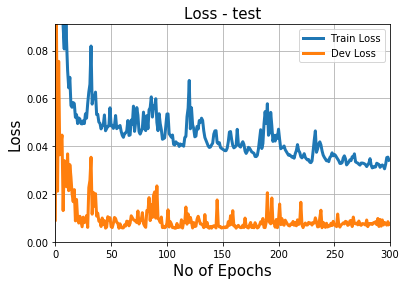

In [10]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()


plot_loss(history_LSTM, title='test')
